**Use the suppplied requirements.txt to set up your virtual env.**

Using pip:

>pip install -r requirements.txt

Using Conda:

>conda create --name \<env_name\> --file requirements.txt

In this notebook we will explore how you can access, query, and use the Syngine models available via IRIS. These models can generate synthetic seismograms for any event/observation pair on Earth.

In [1]:
# import obspy
import obspy
from obspy.taup import TauPyModel
from obspy.core import UTCDateTime, Stream
from obspy.geodetics import locations2degrees

# import the two different clients, and differentiate between names
from obspy.clients.fdsn import Client as Client 
from obspy.clients.syngine import Client as synClient

# other packages
import matplotlib.pyplot as plt
import numpy as np

# matplotlib magic
%matplotlib inline

In [2]:
# set an observatory to use for later analysis
network = "IU"
station = "ANMO"

# get a real station.
irisClient = Client("IRIS")
ANMO = irisClient.get_stations(network=network, 
                           station=station, 
                           format="text")[0][0]

print(ANMO)

Station ANMO (Albuquerque, New Mexico, USA)
	Station Code: ANMO
	Channel Count: None/None (Selected/Total)
	1989-08-29T00:00:00.000000Z - 2000-10-19T16:00:00.000000Z
	Access: None 
	Latitude: 34.95, Longitude: -106.46, Elevation: 1850.0 m
	Available Channels:



We can load all the current models that are available on Syngine, and preview some basic information about them.

In [3]:
# initialize the syngine client
client = synClient()

# load the models
models = client.get_available_models()

Here are the models we'll be using:

| Model name | Resolution (s) | Description |
|:---:|:---:|:---:|
| ak135f_1s | 1-100 | AK135 with density & Q of [Montagner & Kennet (1996)](https://academic.oup.com/gji/article/125/1/229/703026?login=true) |
| ak135f_2s | 2-100 | AK135 with density & Q of [Montagner & Kennet (1996)](https://academic.oup.com/gji/article/125/1/229/703026?login=true) |
| ak135f_5s | 5-100 | AK135 with density & Q of [Montagner & Kennet (1996)](https://academic.oup.com/gji/article/125/1/229/703026?login=true) | 
| iasp91_2s | 2-100 | IASP91  |
| prem_a_2s | 2-100 |  anisotropic PREM  | 
| prem_a_10s | 10-100 |  anisotropic PREM  | 
| prem_a_20s | 20-100 |  anisotropic PREM  |
| prem_a_5s | 5-100 |  anisotropic PREM  |
| prem_i_2s | 2-100 | isotropic PREM |

Full details are available [online](http://ds.iris.edu/ds/products/syngine/). This same data is actually stored in the models dictionary we just generated.

In [4]:
# print the models. Not using print() will maintain the dict structure, so we will just invoke the variable itself.
models

{'ak135f_5s': {'components': 'vertical and horizontal',
  'description': 'ak135 with density & Q of Montagner & Kennet(1996)',
  'max_sampling_period': '1.278000',
  'default_components': 'ZNE',
  'max_event_depth': 750000,
  'length': 3904.29,
  'min_period': 5.125,
  'max_period': '~100',
  'default_dt': '0.25'},
 'prem_a_2s': {'components': 'vertical and horizontal',
  'description': 'anisotropic PREM',
  'max_sampling_period': '0.512260',
  'default_components': 'ZNE',
  'max_event_depth': 750000,
  'length': 3609.89347171399,
  'min_period': 2.09999990463257,
  'max_period': '~100',
  'default_dt': '0.1'},
 'prem_i_2s': {'components': 'vertical and horizontal',
  'description': 'isotropic PREM',
  'max_sampling_period': '0.512260',
  'default_components': 'ZNE',
  'max_event_depth': 750000,
  'length': 3609.89347171448,
  'min_period': 2.09999990463257,
  'max_period': '~100',
  'default_dt': '0.1'},
 'ak135f_2s': {'components': 'vertical and horizontal',
  'description': 'ak135 w

We can now select the event we want to examine. We'll use [the largest earthquake so far in 2021](https://earthquake.usgs.gov/earthquakes/eventpage/us7000dflf/executive) ([alternate link](https://ds.iris.edu/spud/eventplot/18822380)): 

2021-03-04 19:28:33 M8.1 Kermadec Islands, New Zealand

- 29.723°S, 177.279°W

- 28.9 km depth

In [5]:
# load basic event information
event_dict = {"lat": -29.723,
              "lon": 177.279,
              "depth": 28.9}

# load the event IDs for later
event_id_iris = "18822380"
event_id = "GCMT:C202103041928A"

# set the start and endtime, add a significant delay
starttime = UTCDateTime("2021-03-04T19:41:33.000000Z")
endtime = UTCDateTime("2021-03-04T19:56:00.200000Z")

For some reason, obspy will not take this event's ID, not sure what the root cause of the error is.

In [6]:
# try getting the event by its ID
try:
    
    # use the event ID from the IRIS page: https://ds.iris.edu/spud/eventplot/18822380
    event = irisClient.get_events(eventid=event_id_iris, catalog="NEIC PDE")

# print the error
except Exception as error:
    print("Error:", error)

Error: No data available for request.
Detailed response of server:




With the correct imports ([Cartopy](https://scitools.org.uk/cartopy/docs/latest/)), you can rapidly generate overview plots. Let's examine all events on March 4th during the 15-minute window set above. Note that the obspy uses body magnitude (mb) for both querying and plotting.

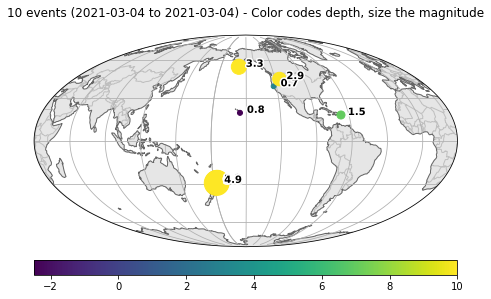

In [7]:
# get all the events between our start and end times 
events = irisClient.get_events(starttime=starttime, endtime=endtime)

# plot. Note the semicolon--it prevents auto-outputs with matplotlib in notebooks
events.plot(projection="global");

Since we can't use the event ID, we can just set some very narrow query parameters to get our event.

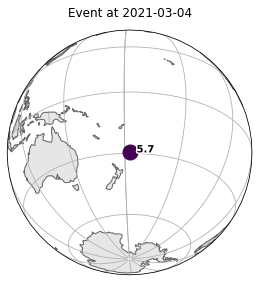

In [8]:
# use narrow time ranges to get the event we want
event = irisClient.get_events(starttime=starttime, endtime=endtime, minmagnitude=5.5)

# plot. Note the semicolon
event.plot(projection="ortho");

Load the [TauPyModel](https://docs.obspy.org/packages/obspy.taup.html) which was dervied from [Crotwell *et al*, 1999](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/70/2/154/142385/The-TauP-Toolkit-Flexible-Seismic-Travel-time-and?redirectedFrom=fulltext).

The package ships with 13 possible models (more than syngine has currently). Since we have three ak135 models in syngine we'll use that for visualization. You can also just call "prem" here, but there's virtually no difference for visual purposes.

In [9]:
# set the model to use and intialize it
tauModel = "ak135"
model = TauPyModel(tauModel)

Now that we have a model, we can [estimate the travel times](https://docs.obspy.org/sphinx3/packages/autogen/obspy.taup.tau.TauPyModel.get_travel_times_geo.html) for each arriving ray from our event to our station. This returns a chronological list of arrivals.

In [10]:
# get the travel times, use the station object and our event dictionary
travel_time = model.get_travel_times_geo(source_depth_in_km=event_dict["depth"], 
                                         source_latitude_in_deg=event_dict["lat"],
                                         source_longitude_in_deg=event_dict["lon"], 
                                         receiver_latitude_in_deg=ANMO.latitude,
                                         receiver_longitude_in_deg=ANMO.longitude)

# print the travel times
print(travel_time)

31 arrivals
	P phase arrival at 807.103 seconds
	PcP phase arrival at 807.240 seconds
	pP phase arrival at 816.443 seconds
	sP phase arrival at 819.778 seconds
	PP phase arrival at 1041.580 seconds
	PKiKP phase arrival at 1084.142 seconds
	pPKiKP phase arrival at 1093.733 seconds
	sPKiKP phase arrival at 1097.017 seconds
	SKiKP phase arrival at 1296.849 seconds
	SKS phase arrival at 1441.854 seconds
	pSKS phase arrival at 1454.454 seconds
	sSKS phase arrival at 1457.809 seconds
	SKKS phase arrival at 1467.663 seconds
	S phase arrival at 1486.241 seconds
	ScS phase arrival at 1486.706 seconds
	pS phase arrival at 1498.275 seconds
	sS phase arrival at 1501.788 seconds
	SP phase arrival at 1566.264 seconds
	PS phase arrival at 1569.954 seconds
	PKKP phase arrival at 1810.327 seconds
	PKIKKIKP phase arrival at 1811.478 seconds
	SS phase arrival at 1880.493 seconds
	SKIKKIKP phase arrival at 2024.164 seconds
	PKIKKIKS phase arrival at 2027.448 seconds
	SKKP phase arrival at 2027.857 seconds

The [obspy.taup.tau.Arrivals class](https://docs.obspy.org/packages/autogen/obspy.taup.tau.Arrivals.html) is hard to work with, or maybe I'm missing something obvious. Here we'll just scrape out the phases so we can visualize them.

In [11]:
# create an empty list to store phases
phase_list = []

# loop through the arrivals
for time in travel_time:
    
    # split the output by spaces
    split = str(time).split(" ")
    
    # get the first item, the phase
    phase = split[0]
    
    # add to to the phase list
    phase_list.append(phase)

We can also visualize the paths of these rays using an [another function](https://docs.obspy.org/packages/autogen/obspy.taup.tau.TauPyModel.get_ray_paths_geo.html). You can pass "plot_all" to this fucntion to see all the phases without the cell above, but now that we have a list of all the phases we can index and slice them if we want to.

In [12]:
# calculate the ray paths for 5 arrivals, use the same calls as above
ray_paths = model.get_ray_paths_geo(source_depth_in_km=event_dict["depth"], 
                                    source_latitude_in_deg=event_dict["lat"],
                                    source_longitude_in_deg=event_dict["lon"], 
                                    receiver_latitude_in_deg=ANMO.latitude,
                                    receiver_longitude_in_deg=ANMO.longitude,
                                    phase_list=phase_list)

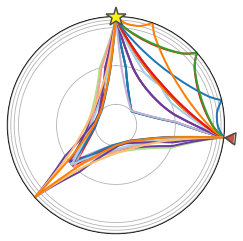

In [13]:
# visualize the ray paths. Again note the semicolon.
ray_paths.plot_rays();

In [14]:
# calculate the distance between the event and detection
distance = locations2degrees(lat1=event_dict["lat"], long1=event_dict["lon"], 
                             lat2=ANMO.latitude, long2=ANMO.longitude)

# print the results
print("{} degrees.".format(round(distance, 2)))

96.6 degrees.


We can now download waveform data for the event from each model using the syngine client function [get_waveforms](https://docs.obspy.org/packages/autogen/obspy.clients.syngine.client.Client.get_waveforms.html). This function is essentially the same as [obspy.clients.fdsn.client.Client.get_waveforms](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html) so you will likely recognize the format.

In [15]:
# select the component we want to model
component = "Z"

# set the sampling rate, only upsampling is allowed so must be equal to or larger than the instruments'
sample_rate = 0.05

# create an empty dictionary to store the results from each model
data = {}

# loop through the 9 available models
for model in models.keys():
    
    # Add a printing call since these can take some time
    print("Processing {}...".format(model))
    
    # some of the models can fail for an unknown reason (related to the time interval?)
    try:
    
        # download the data for each model into the dictionary
        data[model] = client.get_waveforms(model=model, network=network, 
                                           station=station, components=component, 
                                           dt=sample_rate, eventid=event_id,
                                           starttime=starttime, endtime=endtime)
    # print the error if we hit one
    except Exception as error:
        print("Error in {}:".format(model),  error)

Processing ak135f_5s...
Processing prem_a_2s...
Processing prem_i_2s...
Processing ak135f_2s...
Processing prem_a_10s...
Processing iasp91_2s...
Processing prem_a_20s...
Processing prem_a_5s...
Processing ak135f_1s...


We can compare the model results to the real observation, so we need to collected the actual waveform from ANMO for this event.

In [16]:
# initialize a stream
stream = Stream()

# we can use some of the same variables as above
stream = irisClient.get_waveforms(network, station, "00", "BHZ", starttime, endtime)

Let's make sure the stream looks like it's correct.

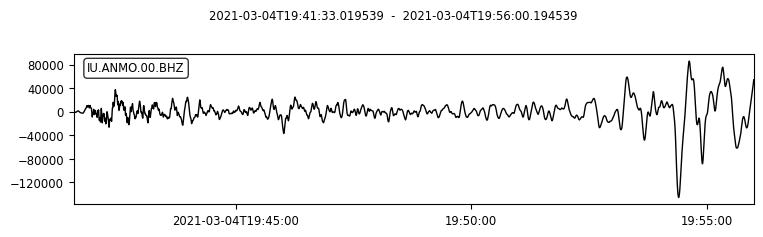

In [17]:
# plot the stream
stream.plot();

That looks pretty good, but it's noisy, we can apply some basic filtering ([Butterworth-bandpass](https://docs.obspy.org/packages/autogen/obspy.signal.filter.bandpass.html)) to improve the results. Since we want to avoid filter ringing we'll modify the get_waveforms call above and trim the results.

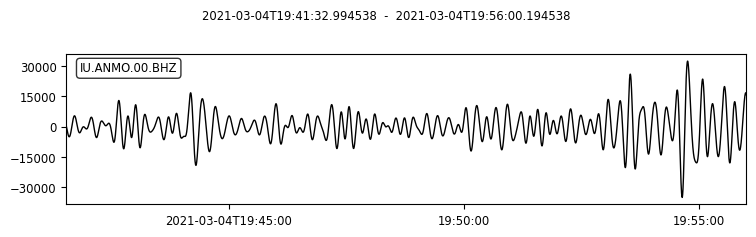

In [18]:
# initialize another stream
stream_proc = Stream()

# overwrite the above stream, and request additional data at the start
stream_proc = irisClient.get_waveforms(network, station, "00", "BHZ", starttime-20, endtime)

# filter the stream with a basic bandpass filter
stream_proc.filter("bandpass", freqmin=0.05, freqmax=0.1)

# trim the extra off the beginning
stream_proc.trim(starttime, endtime)

# plot the filtered results
stream_proc.plot();

Note the change in the y-axis between the two plots, we'll have to account for these when we plot the streams together. Let's take a look at one of the synthetic waveforms.

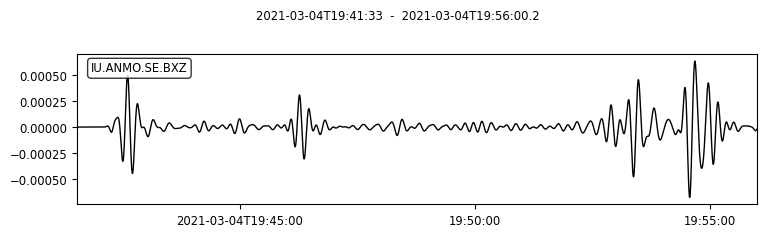

In [19]:
synth_example = data["ak135f_1s"]

# filter the stream with a basic bandpass filter
synth_example.filter("bandpass", freqmin=0.05, freqmax=0.1)

synth_example.plot();

In [20]:
# add the actual observations to our data dictionary
data['Observed'] = stream

Time to do some plotting. Prepare yourself for a lot of matplotlib fun.

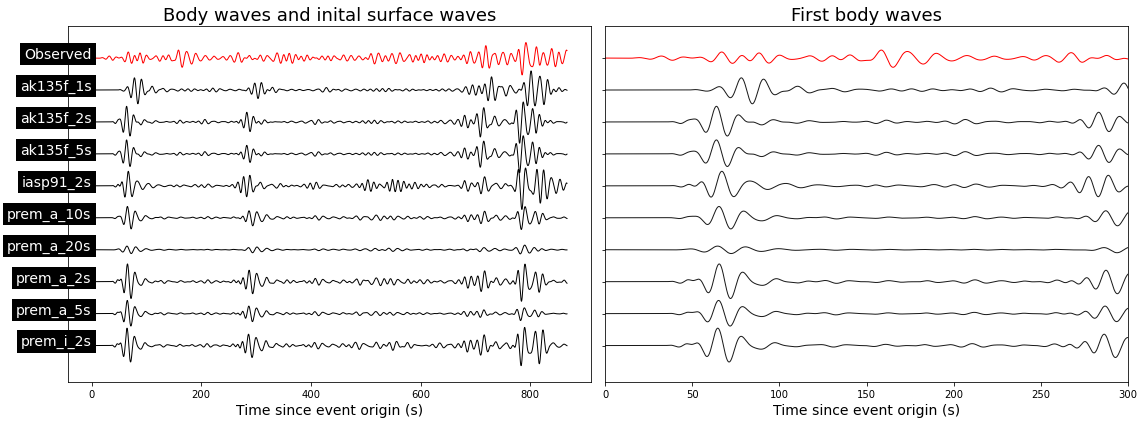

In [21]:
# set up the figure
fig = plt.figure(figsize=(16, 6), tight_layout=True)

# add our two subplots, this is the least gross way I know of
ax = fig.subplots(nrows=1, ncols=2)

# set a scale factor for the model traces
factor = 1E3

# set a factor to scale down the observed trace
actual_factor = 1.5E-5

# loop through our models
for index, model in enumerate(sorted(data.keys())):
    
    # get the trace from the stored downloaded model data
    tr = data[model][0]
    
    # apply the same bandpass filter to all waveforms
    tr = tr.filter("bandpass", freqmin=0.05, freqmax=0.1)
    
    # get the vertical position for the trace to be plotted (top to bottom)
    pos = len(data) - index - 1
    
    # use different scaling and colors for the actual data
    if model == "Observed":
        
        # plot the actual data
        ax[0].plot(tr.times(), tr.data * actual_factor + pos, color="r", lw=1)
        ax[1].plot(tr.times(), tr.data * actual_factor + pos, color="r", lw=1)

    # plot the models
    else:
        
        # plot the traces for each model
        ax[0].plot(tr.times(), tr.data * factor + pos, color="k", lw=1)
        ax[1].plot(tr.times(), tr.data * factor + pos, color="0.1", lw=1)
    
    # we need one line for each model
    ax[0].set_yticks(list(range(len(data))))
    ax[1].set_yticks(list(range(len(data))))
    
    # set the labels to be blank here
    ax[0].set_yticklabels([""] * len(data))
    ax[1].set_yticklabels([""] * len(data))
    
    # set labels
    ax[0].set_xlabel("Time since event origin (s)", fontsize=14)
    ax[0].set_title("Body waves and inital surface waves", fontsize=18)
    ax[1].set_xlabel("Time since event origin (s)", fontsize=14)
    ax[1].set_title("First body waves", fontsize=18)

    # zoom in on the first body waves
    ax[1].set_xlim(0, 300)
    
    # label the models
    ax[0].text(0, pos, model, color="white",
             bbox=dict(facecolor="black", edgecolor="None"),
             ha="right", fontsize=14)

# save and display the figure
plt.savefig("syngine_compare_models.png", dpi=300, facecolor="white")
plt.show()